# Fine Tuning Transformer for MultiLabel Text Classification

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU.

*I have included the code for TPU configuration, but commented it out. If you plan to use the TPU, please comment the GPU execution codes and uncomment the TPU ones to install the packages and define the device.*

In [1]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

C:\Users\gauta\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\gauta\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* Import the file in a dataframe and give it the headers as per the documentation.
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [2]:
#Get data from dektop
df1_train = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\train-00000-of-00002.parquet")
df2_train = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\train-00001-of-00002.parquet")
df_validation = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\validation-00000-of-00001.parquet")
df_test = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\test-00000-of-00001.parquet")

def conv_probs_to_labels(df):
  df['toxicity'] = df['toxicity'].apply(lambda x: 0 if x <0.5 else 1)
  df['severe_toxicity'] = df['severe_toxicity'].apply(lambda x: 0 if x <0.2 else 1)
  df['obscene'] = df['obscene'].apply(lambda x: 0 if x <0.5 else 1)
  df['threat'] = df['threat'].apply(lambda x: 0 if x <0.5 else 1)
  df['insult'] = df['insult'].apply(lambda x: 0 if x <0.5 else 1)
  df['identity_attack'] = df['identity_attack'].apply(lambda x: 0 if x <0.5 else 1)
  df['sexual_explicit'] = df['sexual_explicit'].apply(lambda x: 0 if x <0.5 else 1)
  return df

df1_train = conv_probs_to_labels(df1_train)
df2_train = conv_probs_to_labels(df2_train)
df_validation = conv_probs_to_labels(df_validation)
df_test = conv_probs_to_labels(df_test)

df_train = pd.concat([df1_train,df2_train],axis=0).reset_index()

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(1804874, 9)
(97320, 8)
(97320, 8)


In [4]:
df_train.columns

Index(['index', 'text', 'toxicity', 'severe_toxicity', 'obscene', 'threat',
       'insult', 'identity_attack', 'sexual_explicit'],
      dtype='object')

In [5]:
target_cols = ['toxicity','severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']
df_train[target_cols].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [6]:
#Check null values
df_train.isnull().sum()

index              0
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

In [7]:
#Distribution of the target variable data in terms of proportions.

print("Percent of toxics", round(df_train['toxicity'].sum()/(len(df_train['toxicity']))*100,2), "%")
print("Percent of severe_toxicity", round(df_train['severe_toxicity'].sum()/(len(df_train['severe_toxicity']))*100,2), "%")
print("Percent of obscene", round(df_train['obscene'].sum()/(len(df_train['obscene']))*100,2), "%")
print("Percent of threat", round(df_train['threat'].sum()/(len(df_train['threat']))*100,2), "%")
print("Percent of insult", round(df_train['insult'].sum()/(len(df_train['insult']))*100,2), "%")
print("Percent of identity_attack", round(df_train['identity_attack'].sum()/(len(df_train['identity_attack']))*100,2), "%")
print("Percent of sexual_explicit", round(df_train['sexual_explicit'].sum()/(len(df_train['sexual_explicit']))*100,2), "%")

Percent of toxics 8.0 %
Percent of severe_toxicity 0.36 %
Percent of obscene 0.53 %
Percent of threat 0.24 %
Percent of insult 5.9 %
Percent of identity_attack 0.74 %
Percent of sexual_explicit 0.26 %


In [8]:
#Count of each class

print("Numer of toxics", df_train['toxicity'].sum())
print("Numer of severe_toxicity", df_train['severe_toxicity'].sum())
print("Numer of obscene", df_train['obscene'].sum())
print("Numer of threat", df_train['threat'].sum())
print("Numer of insult", df_train['insult'].sum())
print("Numer of identity_attack", df_train['identity_attack'].sum())
print("Numer of sexual_explicit", df_train['sexual_explicit'].sum())

Numer of toxics 144334
Numer of severe_toxicity 6438
Numer of obscene 9603
Numer of threat 4280
Numer of insult 106534
Numer of identity_attack 13410
Numer of sexual_explicit 4686


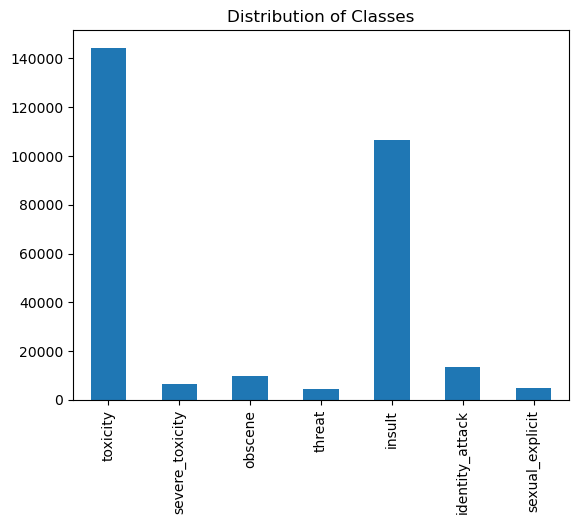

In [9]:
#Distribution of classes
df_train[target_cols].sum().plot(kind = 'bar',title = 'Distribution of Classes')
plt.show()

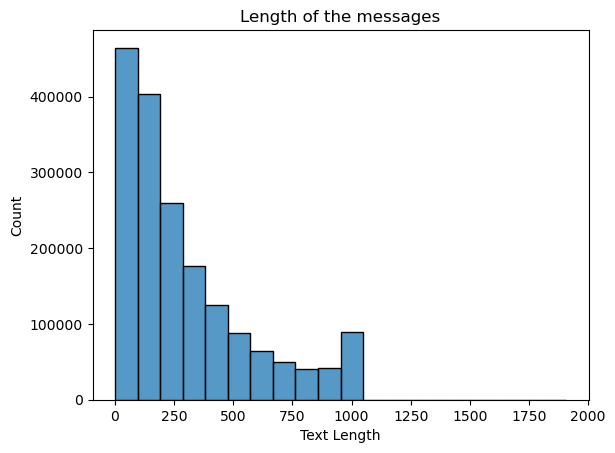

In [10]:
#Length of messages
sns.histplot(df_train.text.str.len(),bins=20)
plt.title('Length of the messages')
plt.xlabel('Text Length')
plt.show()

In [11]:
print(df_train.text.str.len().max())
print(df_train.text.str.len().mean())

1906
297.2343049985761


In [12]:
#Sample Data
#Technique - All positive classes and down sample the negative classes as we have an imbalanced dataset
#Target to keep the training data down to 50000 data points due to the hardware limitations

def sample_dataset(df_train):

    df_positive = df_train[((df_train['toxicity'] == 1) | 
                           (df_train['severe_toxicity'] == 1) | 
                           (df_train['obscene'] == 1) | 
                           (df_train['threat'] == 1) | 
                           (df_train['insult'] == 1) | 
                           (df_train['identity_attack'] == 1) | 
                           (df_train['sexual_explicit'] == 1)) &
                           (df_train.text.str.len() <300)]

    print(df_positive.shape)
    df_negative = df_train[(df_train['toxicity'] == 0) & 
                           (df_train['severe_toxicity'] == 0) & 
                           (df_train['obscene'] == 0) & 
                           (df_train['threat'] == 0) & 
                           (df_train['insult'] == 0) & 
                           (df_train['identity_attack'] == 0) & 
                           (df_train['sexual_explicit'] == 0) &
                           (df_train['text'].str.len() <300)]

    print(df_negative.shape)
    df_negative = df_negative.sample(frac=0.1)
    print(df_negative.shape)

    df_train_final = pd.concat([df_negative,df_positive],axis=0)
    df_train_final = df_train_final.sample(frac = 1).reset_index(drop = True)
    return df_train_final

In [13]:
df_train_sample = sample_dataset(df_train) 
df_train = df_train_sample

(100843, 9)
(1056066, 9)
(105607, 9)


In [14]:
df_train.shape

(206450, 9)

In [ ]:
#df_train.to_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\train.parquet")

In [15]:
df_validation_sample = sample_dataset(df_validation)
df_test_sample = sample_dataset(df_test)

# df_validation_sample.to_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\validation.parquet")
# df_test_sample.to_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\test.parquet")

(5337, 8)
(56781, 8)
(5678, 8)
(5490, 8)
(56867, 8)
(5687, 8)


In [16]:
print(df_validation_sample.shape)
print(df_test_sample.shape)

(11015, 8)
(11177, 8)


In [17]:
#Distribution of the target variable data in terms of proportions.

print("Percent of toxics", round(df_train['toxicity'].sum()/(len(df_train['toxicity']))*100,2), "%")
print("Percent of severe_toxicity", round(df_train['severe_toxicity'].sum()/(len(df_train['severe_toxicity']))*100,2), "%")
print("Percent of obscene", round(df_train['obscene'].sum()/(len(df_train['obscene']))*100,2), "%")
print("Percent of threat", round(df_train['threat'].sum()/(len(df_train['threat']))*100,2), "%")
print("Percent of insult", round(df_train['insult'].sum()/(len(df_train['insult']))*100,2), "%")
print("Percent of identity_attack", round(df_train['identity_attack'].sum()/(len(df_train['identity_attack']))*100,2), "%")
print("Percent of sexual_explicit", round(df_train['sexual_explicit'].sum()/(len(df_train['sexual_explicit']))*100,2), "%")

Percent of toxics 46.89 %
Percent of severe_toxicity 1.77 %
Percent of obscene 3.19 %
Percent of threat 1.83 %
Percent of insult 34.52 %
Percent of identity_attack 4.2 %
Percent of sexual_explicit 1.58 %


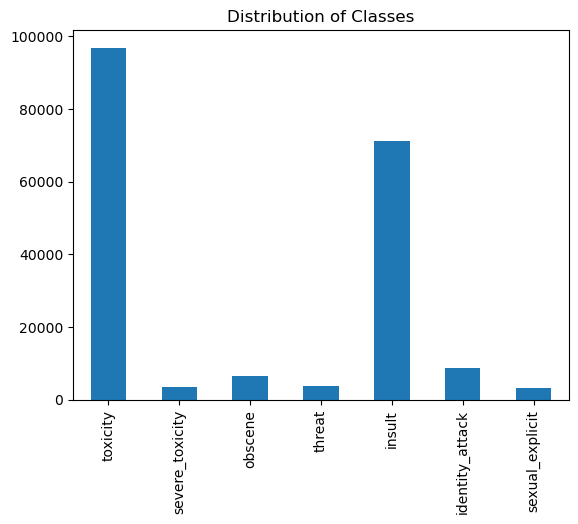

In [18]:
#Distribution of classes
df_train[target_cols].sum().plot(kind = 'bar',title = 'Distribution of Classes')
plt.show()

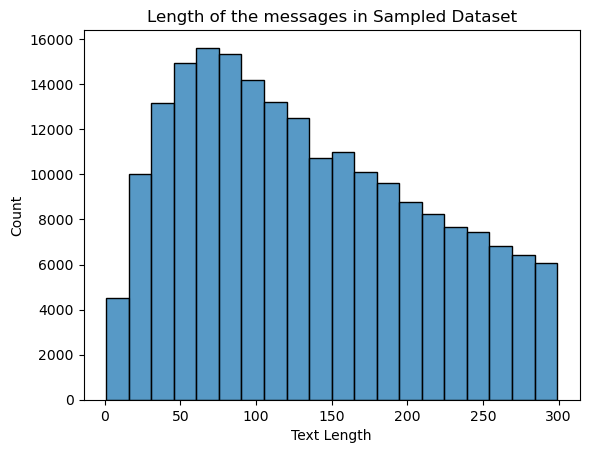

In [19]:
#Length of messages
sns.histplot(df_train.text.str.len(),bins=20)
plt.title('Length of the messages in Sampled Dataset')
plt.xlabel('Text Length')
plt.show()